In [6]:
!git clone https://github.com/kamhar-ngado/Track

Cloning into 'Track'...
remote: Enumerating objects: 14206, done.
remote: Total 14206 (delta 0), reused 0 (delta 0), pack-reused 14206
Receiving objects: 100% (14206/14206), 178.23 MiB | 32.09 MiB/s, done.
Checking out files: 100% (14512/14512), done.


In [7]:
!ls Track

driving_log.csv  IMG


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras 
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
import cv2
import pandas as pd
import ntpath
import random

In [13]:
datadir = 'Track'
colomns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = colomns)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\self driving car simulator\IMG\center_2019_12_21_15_25_24_879.jpg,C:\self driving car simulator\IMG\left_2019_12_21_15_25_24_879.jpg,C:\self driving car simulator\IMG\right_2019_12_21_15_25_24_879.jpg,0.0,0.0,0.0,0.000078
1,C:\self driving car simulator\IMG\center_2019_12_21_15_25_25_021.jpg,C:\self driving car simulator\IMG\left_2019_12_21_15_25_25_021.jpg,C:\self driving car simulator\IMG\right_2019_12_21_15_25_25_021.jpg,0.0,0.0,0.0,0.000084
2,C:\self driving car simulator\IMG\center_2019_12_21_15_25_25_128.jpg,C:\self driving car simulator\IMG\left_2019_12_21_15_25_25_128.jpg,C:\self driving car simulator\IMG\right_2019_12_21_15_25_25_128.jpg,0.0,0.0,0.0,0.000078
3,C:\self driving car simulator\IMG\center_2019_12_21_15_25_25_240.jpg,C:\self driving car simulator\IMG\left_2019_12_21_15_25_25_240.jpg,C:\self driving car simulator\IMG\right_2019_12_21_15_25_25_240.jpg,0.0,0.0,0.0,0.000078
4,C:\self driving car simulator\IMG\center_2019_12_21_15_25_25_342.jpg,C:\self driving car simulator\IMG\left_2019_12_21_15_25_25_342.jpg,C:\self driving car simulator\IMG\right_2019_12_21_15_25_25_342.jpg,0.0,0.0,0.0,0.000080


In [14]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_12_21_15_25_24_879.jpg,left_2019_12_21_15_25_24_879.jpg,right_2019_12_21_15_25_24_879.jpg,0.0,0.0,0.0,0.000078
1,center_2019_12_21_15_25_25_021.jpg,left_2019_12_21_15_25_25_021.jpg,right_2019_12_21_15_25_25_021.jpg,0.0,0.0,0.0,0.000084
2,center_2019_12_21_15_25_25_128.jpg,left_2019_12_21_15_25_25_128.jpg,right_2019_12_21_15_25_25_128.jpg,0.0,0.0,0.0,0.000078
3,center_2019_12_21_15_25_25_240.jpg,left_2019_12_21_15_25_25_240.jpg,right_2019_12_21_15_25_25_240.jpg,0.0,0.0,0.0,0.000078
4,center_2019_12_21_15_25_25_342.jpg,left_2019_12_21_15_25_25_342.jpg,right_2019_12_21_15_25_25_342.jpg,0.0,0.0,0.0,0.000080


<BarContainer object of 25 artists>

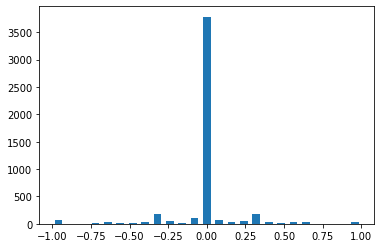

In [16]:
num_bins = 25
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width = 0.05)